In [15]:
import numpy as np #!
from PIL import Image, ImageDraw
import PIL #!
import os #!
import shutil
import imageio
import cv2 #!
import random #!
import matplotlib.pyplot as plt
import sys
import time #!
import config

In [16]:
def main(do_new_data = True):
    """
    It imports injection(marker, named "injection.png"), bakcground photo(from src_dir), combines them by injecting marker in random position of background
    saves it later to dst_dir
    """
    src_dir = config.BG_PIC_SRC_DIR #source dir
    dst_dir = config.PIC_SRC_DIR #destination dir
    file_ext = '.jpeg' #file extenstion
    number_of_photos = 100 #limit of created photos (max 20k)
    limit_per_part = 1000 #photos per batch
    start_time =time.time()
    
    
    
    
    
    if not os.path.exists(dst_dir): #if dir not present, make it
        os.mkdir(dst_dir)
        
    elif do_new_data == True:
        print("Data directory detected, removing it content")
        shutil.rmtree(dst_dir, ignore_errors=True)
        print("making new dir")
        os.mkdir(dst_dir)
        
    make_data(src_dir,dst_dir,limit_total = number_of_photos,
              limit_per_part=limit_per_part,file_ext = file_ext)
    print('Took: {0} seconds'.format(time.time() - start_time))

In [17]:
def effect_random(src): #put effect randomly on whole image
  
    base =  "image" + "_"
    # making lookup table
    min_table = 50
    max_table = 205
    diff_table = max_table - min_table
    gamma1 = 0.5
    gamma2 = 1.5

    #choose 1 effect from 6 types of effect randomly
    x=random.randrange(6)
    #print(x)
    if x==0:
        LUT_HC = np.arange(256, dtype = 'uint8' )
        #making LUT for high contrast
        for i in range(0, min_table):
            LUT_HC[i] = 0
        for i in range(min_table, max_table):
            LUT_HC[i] = 255 * (i - min_table) / diff_table
        for i in range(max_table, 255):
            LUT_HC[i] = 255
        high_cont_img = cv2.LUT(src, LUT_HC)
         #high contrast
        
        return high_cont_img
    if x==1:
        LUT_LC = np.arange(256, dtype = 'uint8' )
        # making LUT for low contrast and gamma correction
        for i in range(256):
            LUT_LC[i] = min_table + i * (diff_table) / 255
            #LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
            #LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)
        low_cont_img = cv2.LUT(src, LUT_LC)
          #low contrast
        
        return low_cont_img
    if x==2:
        LUT_G1 = np.arange(256, dtype = 'uint8' )
        for i in range(256):
            LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
        g1_img=cv2.LUT(src, LUT_G1)
         # when gunnma = 0.5
        
        return g1_img
    if x==3:
        LUT_G2 = np.arange(256, dtype = 'uint8' )
        for i in range(256):
            LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)
        g2_img=cv2.LUT(src, LUT_G2)
        #when gunma = 1.5
        
        return g2_img 
    if x==4:
        row,col,ch= src.shape
        mean = 0
        sigma = 15
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        gauss_img = src + gauss

        
        #gaussian noise
        
        return gauss_img
    if x==5:
        row,col,ch = src.shape
        s_vs_p = 0.5
        amount = 0.004
        out = src.copy()
        # Salt mode
        num_salt = np.ceil(amount * src.size * s_vs_p)
        coords = [np.random.randint(0, i-1 , int(num_salt))
            for i in src.shape]
        out[coords[:-1]] = (255,255,255)

        # Pepper mode
        num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i-1 , int(num_pepper))
            for i in src.shape]
        out[coords[:-1]] = (0,0,0)
         #salt&pepper noise
        return out

In [18]:
def cvpaste(img, imgback, x, y, angle, scale):  
        # x and y are the distance from the center of the background image 
        r = img.shape[0]
        c = img.shape[1]
        rb = imgback.shape[0]
        cb = imgback.shape[1]
        hrb=round(rb/2)
        hcb=round(cb/2)
        hr=round(r/2)
        hc=round(c/2)

        # Copy the forward image and move to the center of the background image
        imgrot = np.zeros((rb,cb,3),np.uint8)
        imgrot[hrb-hr:hrb+hr,hcb-hc:hcb+hc,:] = img[:hr*2,:hc*2,:]

        # Rotation and scaling
        M = cv2.getRotationMatrix2D((hcb,hrb),angle,scale)
        imgrot = cv2.warpAffine(imgrot,M,(cb,rb))
        # Translation
        M = np.float32([[1,0,x],[0,1,y]])
        imgrot = cv2.warpAffine(imgrot,M,(cb,rb))

        # Makeing mask
        imggray = cv2.cvtColor(imgrot,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(imggray, 10, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        # Now black-out the area of the forward image in the background image
        img1_bg = cv2.bitwise_and(imgback,imgback,mask = mask_inv)

        # Take only region of the forward image.
        img2_fg = cv2.bitwise_and(imgrot,imgrot,mask = mask)

        # Paste the forward image on the background image
        imgpaste = cv2.add(img1_bg,img2_fg)

        return imgpaste


In [26]:
#Proceed with injetion on background photo
def inject_photo(background, name, dst_dir,
                 injected_photo=os.path.join(config.DATA_DIR ,"injection.png")):
    """
    Function makes injection into 'Background' from ' injected_photo', 
    renames it and places it in dst_dir 
    """
    #Import images
    imgback = cv2.imread(background,-1)
    #imgback = image_resize(imgback, width = config.CNN_IN_WIDTH, height = config.CNN_IN_HEIGHT)
    img = cv2.imread(injected_photo,-1)
    #Get size
    rows,cols,channels = imgback.shape
    #Random position of injection
    x=int(random.uniform(-cols/4,cols/4)) # x distancec for x axis from center 
    y=int(random.uniform(-rows/4,cols/4)) # y y distance from center
    angle=int(random.randint(0, 45)) # decide angle from 0 to 360
    scale=float(random.uniform(0.5,2))    # chose the sholipe logo sacale 
    #combine everything

    
    imgpaste = cvpaste(img, imgback, x, y, angle, scale)
    name = os.path.join(dst_dir, name)
    img_with_effect = effect_random(imgpaste)
    cv2.imwrite(name, img_with_effect)
    
    #Calculation of ground truth for photo
    a = 64*scale*(np.sin(np.radians(angle))+np.cos(np.radians(angle)))
    from_edge = a/2
    x1 = int(x + 128 - from_edge)
    x2 = int(x + 128 + from_edge)
    y1 = int(y + 128 - from_edge)
    y2 = int(y + 128 + from_edge)
    return x1,y1,x2,y2,x,y

In [27]:
#Not in use, left for possible future use
def copy_rename(background,name, dst_dir):
    """
    Function converts background picture to 3 channel picture in dst_dir with new name
    """
    #import
    img = cv2.imread(background,-1)
    #convert to 4 channel
    new_img = effect_random(img)
    #get new name
    name = os.path.join(dst_dir,name)
    #Save
    cv2.imwrite(name, new_img)

In [38]:
def make_data(src_dir,dst_dir,limit_total = 50, file_ext='.png', limit_per_part=10, only_injected = True):
    """
    Function used for handling data in procces of creating data for network
    Please overwrite default parameters when calling, defaults used for debugging
    """
    #Params
    n = 0; k=1;
    num_pics = len(os.listdir(src_dir))
    label = np.zeros(shape=(limit_total, 5))
    current_limit = limit_per_part
    print("creating {} samples".format(limit_total))
    new_dst_dir = dst_dir
    
#Creation of data
#Needs photos with 
#in first part it creates injected photos, in second copies photos
#Mark with 1 in first coulumn tells that injection is present, in second that it is absent(one-hot code)
    for f in os.listdir(src_dir):
        #get name of imported background pic
        src_file = os.path.join(src_dir,f)
        #check if file is picture with .png extension
        if f.endswith(file_ext):
            if n == limit_total: break
            
                    
            #PHOTO WITH INJECTION
            n+=1
            new_name = ('{0}.png'.format(n))
            x1,y1,x2,y2,_,_ = inject_photo(src_file, new_name, new_dst_dir)
            label[n-1] = [1,x1,y1,x2,y2]
            
            
            if only_injected == False:
                #PHOTO WITHOUT INJECTION
                n+=1
                new_name = ('{0}.png'.format(n))
                copy_rename(src_file, new_name, new_dst_dir)
                #assign labels to array
                label[n-1] =[0,0,0,0,0]
            
            #Check progress
            if (n%(limit_total/10)==0):
                print("done {}%".format((n/limit_total)*100))
        #save file with labels to "data" dir
        label_dst = config.LABEL_ORG
        label.astype(int)
        np.save(label_dst,label)
    print("Created {} files".format(n))

In [39]:
if __name__ == '__main__' :

    main()
    


Data directory detected, removing it content
making new dir
creating 100 samples
done 10.0%


D:\Python\envs\tf\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\Python\envs\tf\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


done 20.0%
done 30.0%
done 40.0%
done 50.0%
done 60.0%
done 70.0%
done 80.0%
done 90.0%
done 100.0%
Created 100 files
Took: 1.0480597019195557 seconds


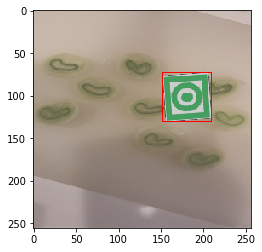

In [40]:
import my_tools
#my_tools.show_image(2)
my_tools.show_label_on_img(5)

### In case of conversion
img = Image.open('injection.png') <br>
img = img.convert('RGB') <br>
img.save('injection.png') <br>

### Check if labels were created
check_name = np.load("label.npy") <br>
print(check_name) <br>

### For resizing injection
inj = os.path.join(config.DATA_DIR, "injection.png")<br>
inj = cv2.imread(inj,-1)<br>
print(inj.shape)<br>
inj = image_resize(inj, width = 16, height = 16) <br>
cv2.imwrite("injection2.png",inj)<br>


In [10]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized